# Geographic SHAP

This notebook contains the Python code of the blog post "Geographic SHAP" on https://lorentzen.ch/.

## Load and inspect data

In [2]:
%load_ext lab_black

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

df = fetch_openml(data_id=43093, as_frame=True)
X, y = df.data, np.log(df.target)
X.head()

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


c:\Users\Michael\anaconda3\envs\shap_tutorial\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,LATITUDE,LONGITUDE,PARCELNO,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,6.222801e+11,9375.0,1753.0,0.0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67.0,0.0,8.0,4.0
1,25.891324,-80.153968,6.222801e+11,9375.0,1715.0,0.0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63.0,0.0,9.0,4.0
2,25.891334,-80.153740,6.222801e+11,9375.0,2276.0,49206.0,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61.0,0.0,2.0,4.0
3,25.891765,-80.152657,6.222801e+11,12450.0,2058.0,10033.0,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63.0,0.0,9.0,4.0
4,25.891825,-80.154639,6.222801e+11,12800.0,1684.0,16681.0,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42.0,0.0,7.0,4.0


## Data split and model

In [3]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

x_coord = ["LONGITUDE", "LATITUDE"]
x_nongeo = ["TOT_LVG_AREA", "LND_SQFOOT", "structure_quality", "age"]
x = x_coord + x_nongeo

X_train, X_valid, y_train, y_valid = train_test_split(
    X[x], y, test_size=0.2, random_state=30
)

# Fit XGBoost model with early stopping
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = dict(learning_rate=0.2, objective="reg:squarederror", max_depth=5)

fit = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dvalid, "valid")],
    verbose_eval=100,
    early_stopping_rounds=20,
    num_boost_round=1000,
)

[0]	valid-rmse:9.79090
[100]	valid-rmse:0.15110
[200]	valid-rmse:0.14720
[280]	valid-rmse:0.14690


## SHAP dependence plots for selected features

c:\Users\Michael\anaconda3\envs\shap_tutorial\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


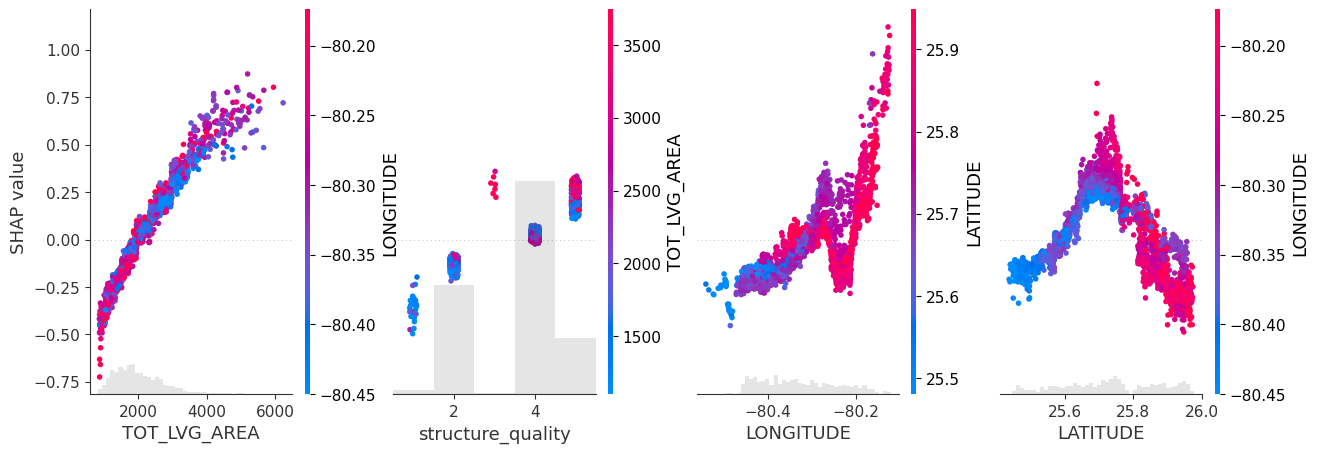

In [4]:
import shap

xgb_explainer = shap.Explainer(fit)
shap_values = xgb_explainer(X_valid)

v = ["TOT_LVG_AREA", "structure_quality", "LONGITUDE", "LATITUDE"]
shap.plots.scatter(shap_values[:, v], color=shap_values[:, v])

## Total coordinate effects

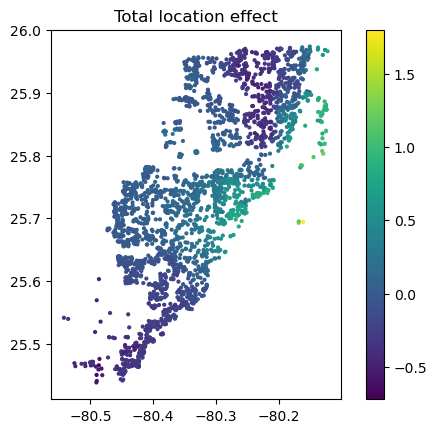

In [21]:
shap_coord = shap_values[:, x_coord]
plt.scatter(*list(shap_coord.data.T), c=shap_coord.values.sum(axis=1), s=4)
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")
plt.colorbar()
plt.title("Total location effect")
plt.show()

## Modification

- Use more geographic features
- Allow interactions only between geographic features

[0]	valid-rmse:9.79161
[100]	valid-rmse:0.16196
[200]	valid-rmse:0.15796
[300]	valid-rmse:0.15658
[397]	valid-rmse:0.15582


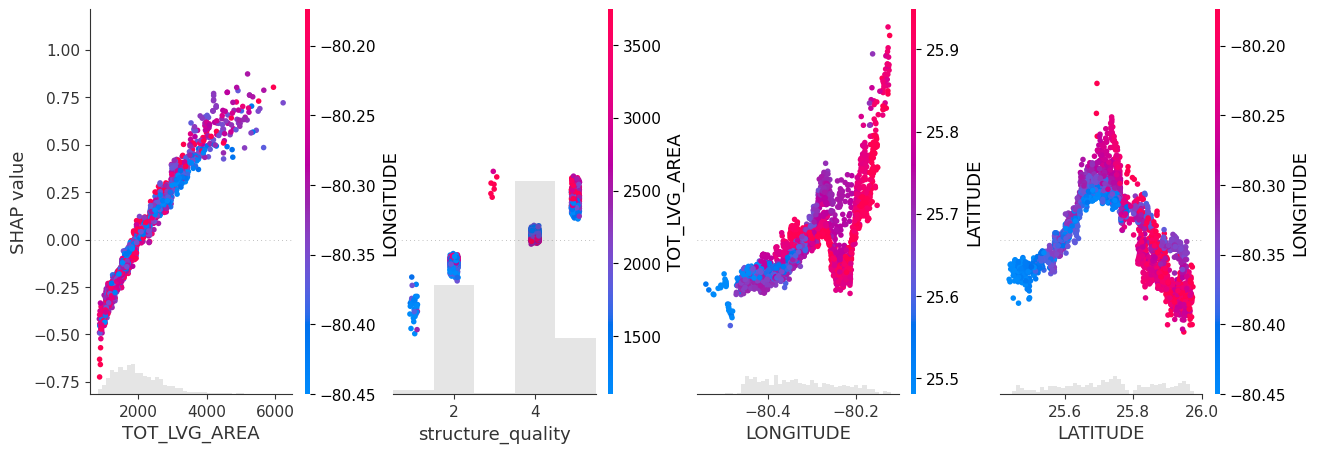

In [10]:
# Extend the feature set
more_geo = ["CNTR_DIST", "OCEAN_DIST", "RAIL_DIST", "HWY_DIST"]
x2 = x + more_geo

X_train2, X_valid2 = train_test_split(X[x2], test_size=0.2, random_state=30)

dtrain2 = xgb.DMatrix(X_train2, label=y_train)
dvalid2 = xgb.DMatrix(X_valid2, label=y_valid)

# Build interaction constraint vector
ic = [x_coord + more_geo, *[[z] for z in x_nongeo]]

# Modify parameters
params["interaction_constraints"] = ic

fit2 = xgb.train(
    params=params,
    dtrain=dtrain2,
    evals=[(dvalid2, "valid")],
    verbose_eval=100,
    early_stopping_rounds=20,
    num_boost_round=1000,
)

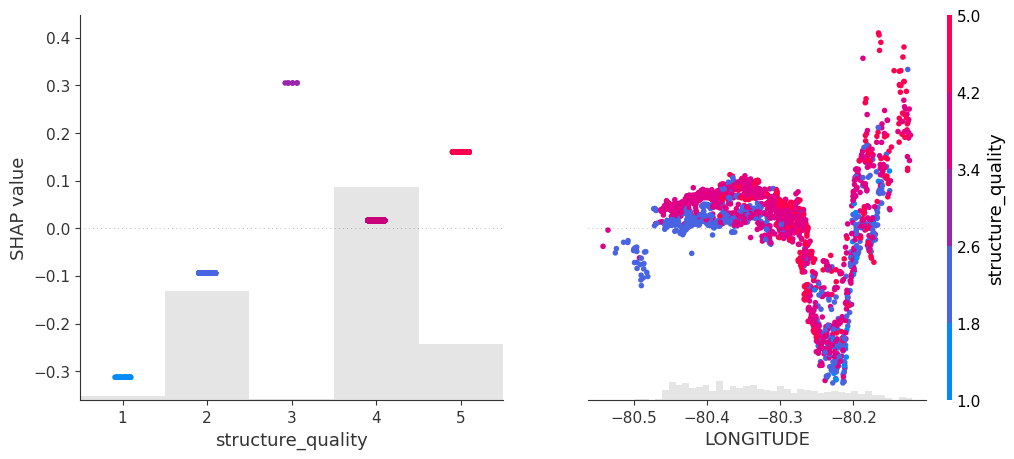

In [12]:
# SHAP analysis
xgb_explainer2 = shap.Explainer(fit2)
shap_values2 = xgb_explainer2(X_valid2)

v = ["structure_quality", "LONGITUDE"]
shap.plots.scatter(shap_values2[:, v], color=shap_values2[:, v])

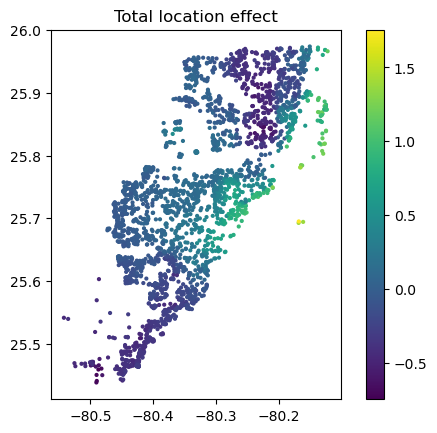

In [20]:
shap_coord2 = shap_values2[:, x_coord]
c = shap_values2[:, x_coord + more_geo].values.sum(axis=1)
plt.scatter(*list(shap_coord2.data.T), c=c, s=4)
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")
plt.colorbar()
plt.title("Total location effect")
plt.show()